<a href="https://colab.research.google.com/github/a0pro0b/Implementing-Data-Mining-in-Retail-Analysis-with-Big-Data/blob/main/Implementing%20Data%20Mining%20in%20Retail%20Analysis%20with%20Big%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing Data Mining in Retail Analysis with Big Data**

**Problem Statement:**

Retail analytics is the process of delivering analytical data on inventory levels, supply chain movement, customer demand, sales, and other important factors for marketing and procurement choices. Demand and supply data analytics may be utilized to manage procurement levels as well as make marketing decisions. Retail analytics provides us with precise consumer insights and insights into the organization's business and procedures, as well as the scope and need for development.

Aside from inventory management, many retailers employ analytics to determine customer patterns and shifting preferences by merging various sources. Businesses may discover developing trends, and better predict them by combining sales data with a range of criteria. This is strongly related to marketing functions, which also benefit from analytics.

Companies may use retail analytics to strengthen their marketing strategies by better grasping individual preferences and gaining more detailed data. They may design strategies that focus on people and have a greater success rate by combining demographic data with information such as purchasing patterns, preferences, and purchase history.

In [ ]:
#install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#download spark3.0.0
!wget -q http://apache.osuosl.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
#unzip 
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
#install findspark 
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
!wget --continue https://raw.githubusercontent.com/a0pro0b/Stark/master/features.csv
!wget --continue https://raw.githubusercontent.com/a0pro0b/Stark/master/train.csv
!wget --continue https://raw.githubusercontent.com/a0pro0b/Stark/master/test.csv
!wget --continue https://raw.githubusercontent.com/a0pro0b/Stark/master/stores.csv
!wget --continue https://raw.githubusercontent.com/a0pro0b/Stark/master/sampleSubmission.csv

--2022-03-23 09:31:24--  https://raw.githubusercontent.com/a0pro0b/Stark/master/features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592289 (578K) [text/plain]
Saving to: ‘features.csv’

features.csv        100%[===================>] 578.41K  --.-KB/s    in 0.05s   

2022-03-23 09:31:25 (11.1 MB/s) - ‘features.csv’ saved [592289/592289]

--2022-03-23 09:31:25--  https://raw.githubusercontent.com/a0pro0b/Stark/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12842546 (12M) [text/plain]
Saving to: ‘train.csv’

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

**train.csv**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week

**test.csv**

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

from math import sqrt
import warnings

In [ ]:
train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')
#train_df.head()

In [ ]:
train_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [ ]:
train_df.shape

(421570, 5)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [ ]:
train_df.isnull().head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


In [ ]:
train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [ ]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
features_df.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [ ]:
features_df.shape

(8190, 12)

In [ ]:
features_df.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [ ]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
stores_df.columns

Index(['Store', 'Type', 'Size'], dtype='object')

In [ ]:
stores_df.shape

(45, 3)

In [ ]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

labels = stores_df["Type"].value_counts()[:10].index
values = stores_df["Type"].value_counts()[:10].values

colors=stores_df["Type"]

#fig = go.Figure(data=[go.Pie(labels,values)])
fig = px.pie(values=values, names=labels)

fig.show()

Here from the above pie chart it is clearly visible that Type c has the minimum number of stores while Type A has the maximum number of stores.

In [ ]:
dataset = features_df.merge(stores_df, how='inner', on='Store')
dataset.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [ ]:
dataset.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size'],
      dtype='object')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 903.8+ KB


In [ ]:
dataset.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,130287.600000
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259,63115.971429
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,70713.000000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,126512.000000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,202307.000000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000


In [ ]:
labels = dataset["Type"].value_counts()[:10].index  # Taking the top 10 index
values = dataset["Type"].value_counts()[:10].values  # Taking the top 10 values

colors=dataset["Type"]

#fig = go.Figure(data=[go.Pie(values,labels)])
fig = px.pie(values=values, names=labels)

fig.show()

Here from the above pie chart it is clearly visible that Type c has the minimum number of stores while Type A has the maximum number of stores.

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [ ]:
labels = train_df["Store"].value_counts()[:10].index  # Taking the top 10 index
values = train_df["Store"].value_counts()[:10].values  # Taking the top 10 values

colors=train_df["Store"]

#fig = go.Figure(data=[go.Pie(values,labels)])
fig = px.pie(values=values, names=labels)

fig.show()

Here we are visualizing the top 10 stores in the training dataset along with their percentage which let us know that all 10 of the stores in the training dataset have equal distribution in the dataset.

In [ ]:
labels = train_df['IsHoliday'].value_counts().index # Taking the all index
values = train_df['IsHoliday'].value_counts().values  # Taking the all values

colors=train_df['IsHoliday']

#fig = go.Figure(data=[go.Pie(values,labels)])
fig = px.pie(values=values, names=labels)
fig.show()

So in this pie chart it is seen that 93% of the time there is no holiday in the stores.

In [ ]:
test_df.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

In [ ]:
test_df.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
from datetime import datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
#train_df.info()

In [ ]:
dataset['Day'] = dataset.Date.dt.day # for the day data
dataset['Week'] = dataset.Date.dt.week # for the week data
dataset['Month'] = dataset.Date.dt.month # for the month data
dataset['Year'] = dataset.Date.dt.year # for the year data

dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Day,Week,Month,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,5,2,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,12,6,2,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,19,7,2,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,26,8,2,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,5,9,3,2010


In [ ]:
train_merge = train_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
test_merge = test_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

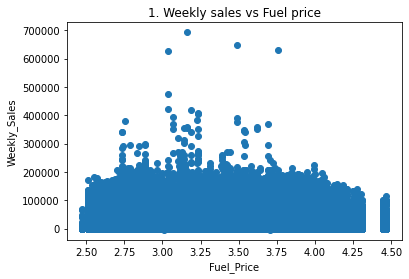

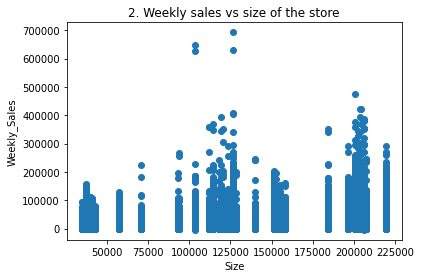

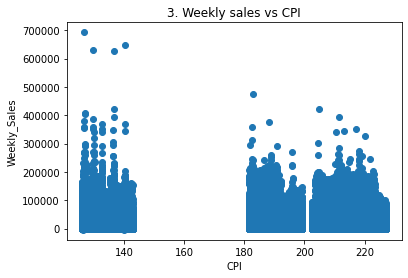

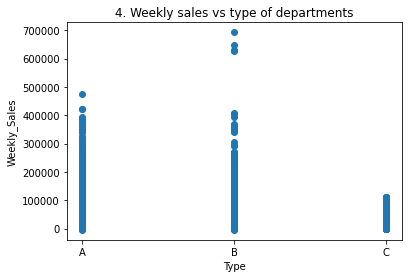

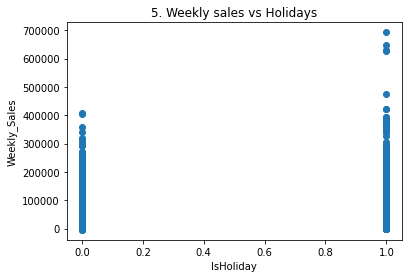

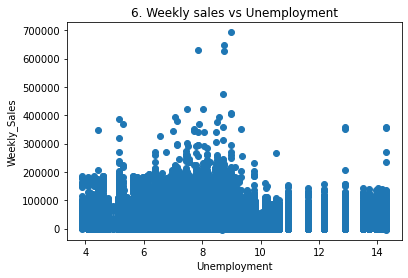

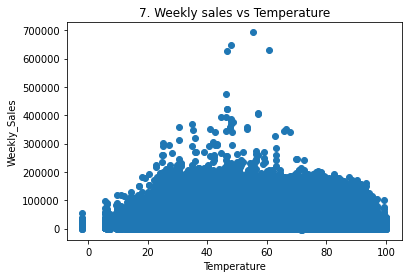

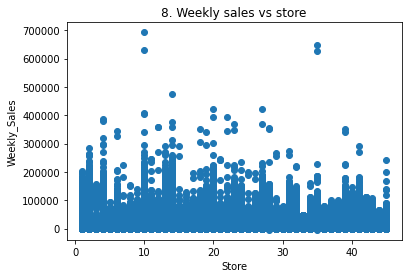

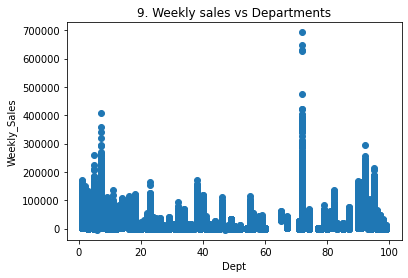

In [ ]:
def scatter(train_merge, column, name):
    plt.figure()
    plt.scatter(train_merge[column] , train_merge['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
    plt.title(name)

scatter(train_merge, 'Fuel_Price', '1. Weekly sales vs Fuel price')  # with respect to Fuel_Price
scatter(train_merge, 'Size', '2. Weekly sales vs size of the store')  # with respect to Size
scatter(train_merge, 'CPI', '3. Weekly sales vs CPI')  # with respect to CPI
scatter(train_merge, 'Type', '4. Weekly sales vs type of departments')  # with respect to Type
scatter(train_merge, 'IsHoliday', '5. Weekly sales vs Holidays') # with respect to IsHoliday
scatter(train_merge, 'Unemployment', '6. Weekly sales vs Unemployment')  # with respect to Unemployment
scatter(train_merge, 'Temperature', '7. Weekly sales vs Temperature') # with respect to Temperature
scatter(train_merge, 'Store', '8. Weekly sales vs store') # with respect to Store
scatter(train_merge, 'Dept', '9. Weekly sales vs Departments')  # with respect to Dept

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



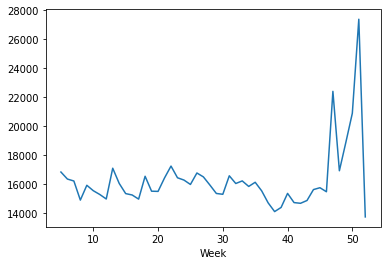

In [ ]:
weekly_sales_2010 = train_merge[train_merge['Year']==2010]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values) # for plotting then lineplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



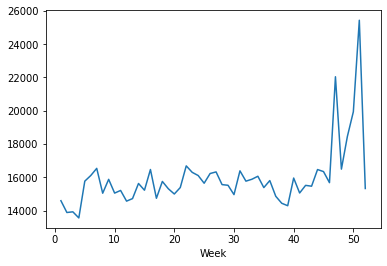

In [ ]:
weekly_sales_2011 = train_merge[train_merge['Year']==2011]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values) # for plotting then lineplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



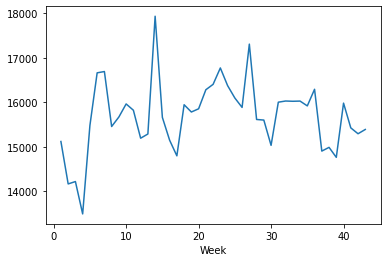

In [ ]:
weekly_sales_2012 = train_merge[train_merge['Year']==2012]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values) # for plotting then lineplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



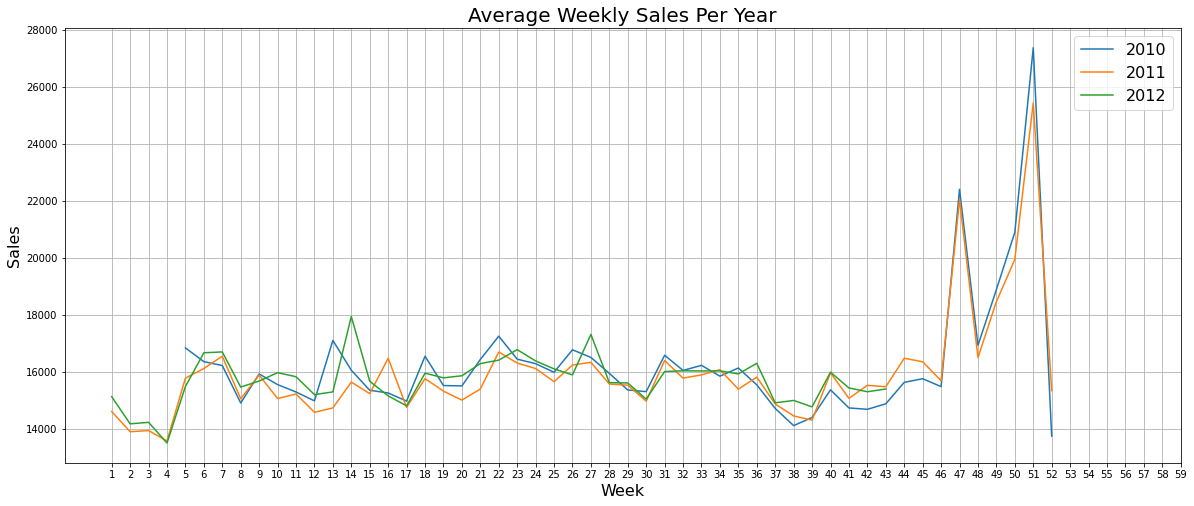

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1,60, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales Per Year', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



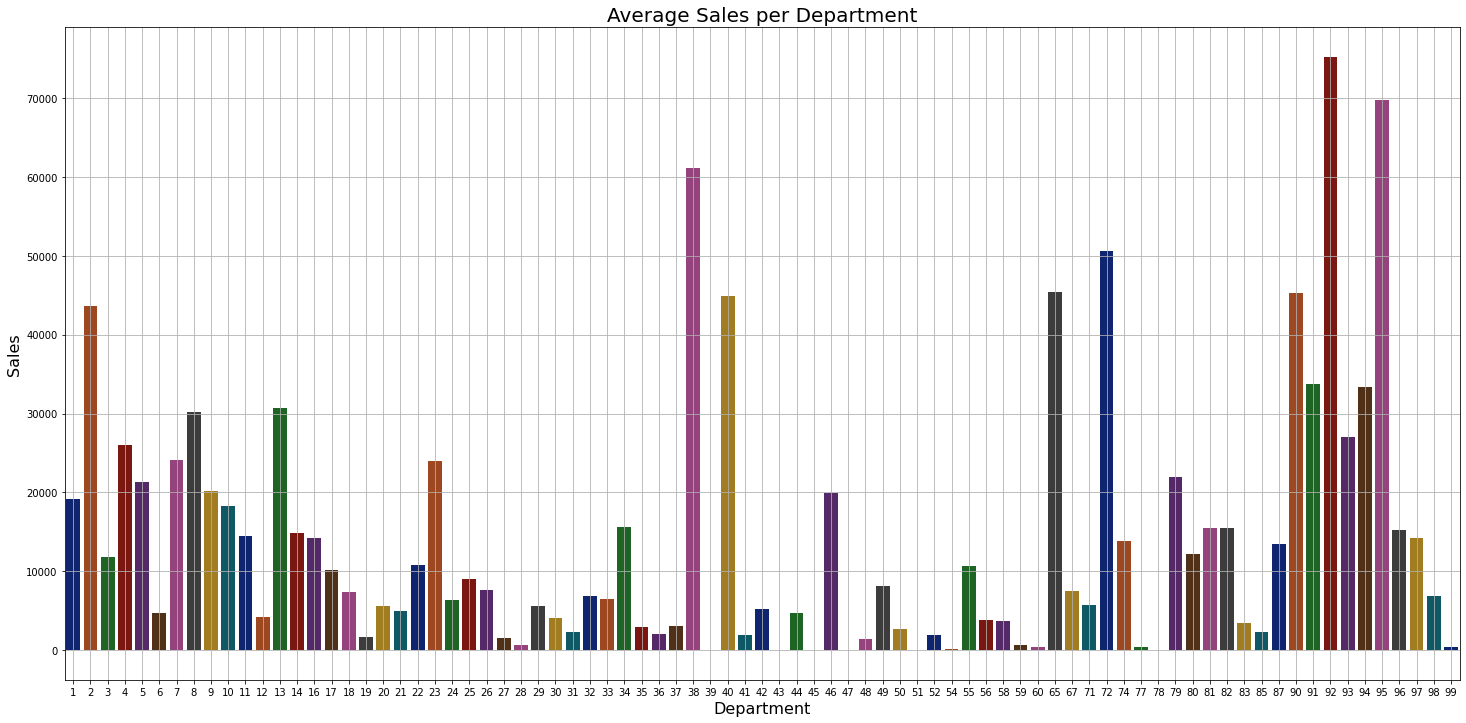

In [ ]:
weekly_sales = train_merge['Weekly_Sales'].groupby(train_merge['Dept']).mean()
plt.figure(figsize=(25,12))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales per Department', fontsize=20)
plt.xlabel('Department', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



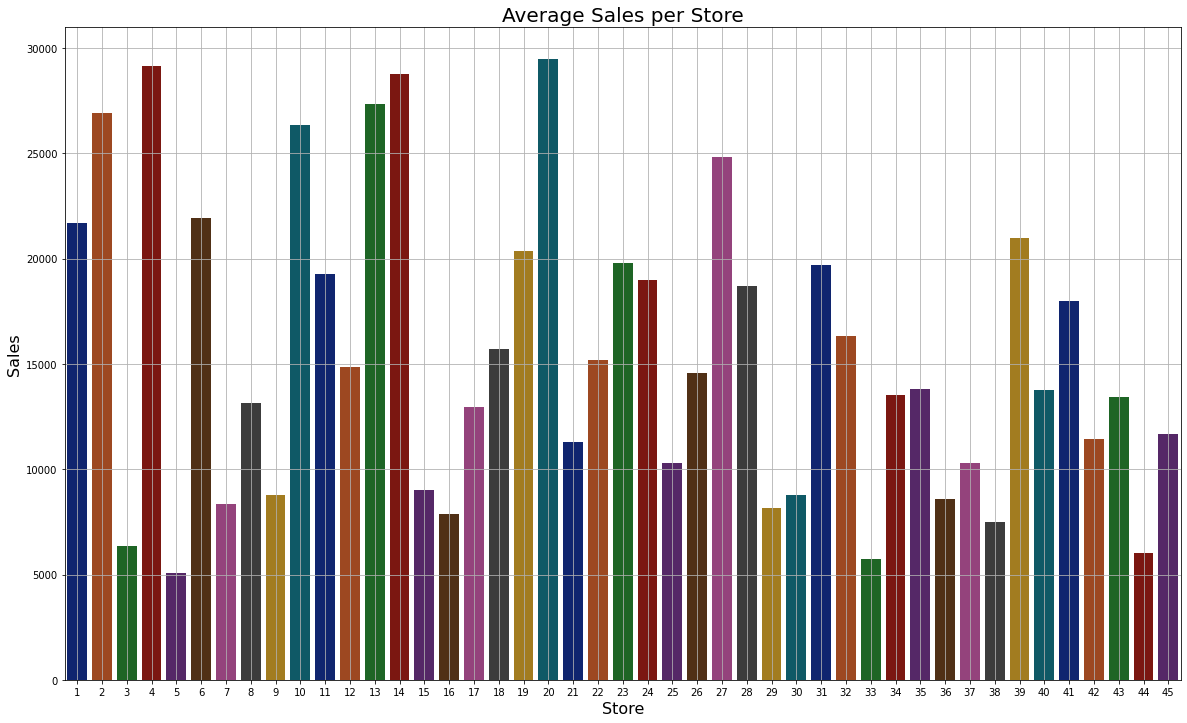

In [ ]:
weekly_sales = train_merge['Weekly_Sales'].groupby(train_merge['Store']).mean()
plt.figure(figsize=(20,12))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales per Store', fontsize=20)
plt.xlabel('Store', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



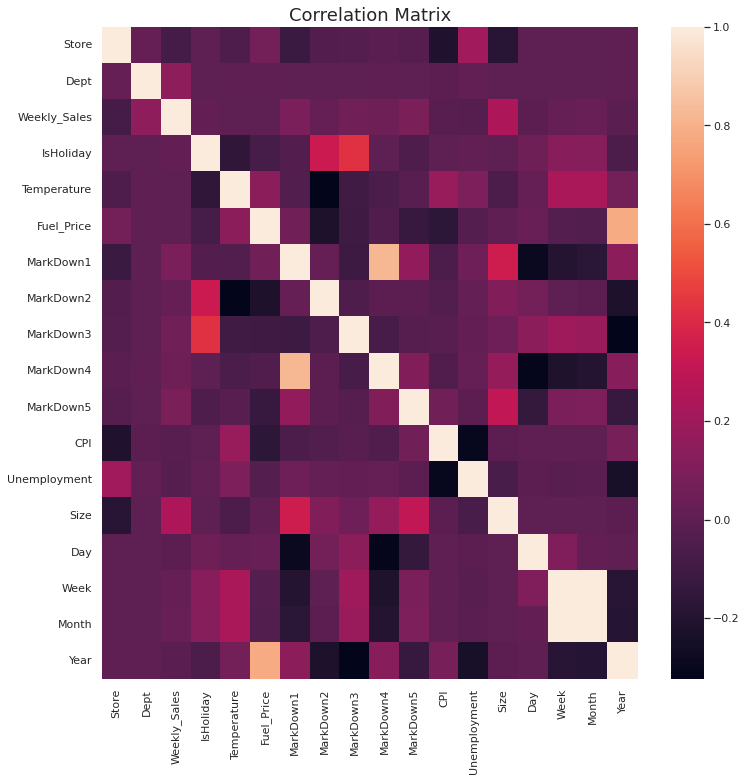

In [ ]:
plt.figure(figsize=(12,12))
sns.set(style = "white")
corr = train_merge.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
#f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr)
plt.show()

In [ ]:
#train_merge = train_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
#test_merge = test_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

In [ ]:
train_merge.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,12,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,19,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,26,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,5,9,3,2010


In [ ]:
test_merge.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2,44,11,2012
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,9,45,11,2012
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,16,46,11,2012
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,23,47,11,2012
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,30,48,11,2012


In [ ]:
train_merge.replace({'A': 1, 'B': 2,'C':3},inplace=True)
train_merge.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Week',
       'Month', 'Year'],
      dtype='object')

In [ ]:
test_merge.replace({'A': 1, 'B': 2,'C':3},inplace=True)
test_merge.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size', 'Day', 'Week', 'Month', 'Year'],
      dtype='object')

In [ ]:
train_merge.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Day                  0
Week                 0
Month                0
Year                 0
dtype: int64

In [ ]:
test_merge.isnull().sum()
test=test_merge

In [ ]:
Y_train = train_merge['Weekly_Sales']
targets = Y_train.copy()
train= train_merge.drop(['Weekly_Sales'],axis=1)

In [ ]:
# Let's also identify the numeric and categorical columns.
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train.select_dtypes('object').columns.tolist()
print(numeric_cols)
print("------------------------------------------------------------\n")
print(categorical_cols)

['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Week', 'Month', 'Year']
------------------------------------------------------------

[]


In [ ]:
# Importing all the libraries
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns", 120)
#pd.set_option("display.max_rows", 120)


In [ ]:
# Create the imputer
imputer = SimpleImputer(missing_values= np.NaN, strategy='mean')
# Fit the imputer to the numeric columns
imputer.fit(train[numeric_cols])
#Replace all the null values
train[numeric_cols] =imputer.transform(train[numeric_cols])

In [ ]:
# Check if there is any null value
train.isnull().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Day             0
Week            0
Month           0
Year            0
dtype: int64

Evaluate Algorithms

In [ ]:
# importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Create the scaler
scaler = MinMaxScaler()
# Fit the scaler to the numeric columns
scaler.fit(train[numeric_cols])
# Transform and replace the numeric columns
train[numeric_cols] = scaler.transform(train[numeric_cols])

In [ ]:
train[numeric_cols].describe().loc[['min', 'max']]

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# 'Date' is irrelevant and Drop it from data.
train= train.drop(['Date'],axis=1)
test = test.drop(['Date'], axis=1)

In [ ]:
# Preparing the dataset:
X_train =train[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
X_test = test[['Store', 'Dept','IsHoliday', 'Size', 'Week', 'Type', 'Year']]
print(X_train.columns)
print(X_test.columns)

Index(['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year'], dtype='object')
Index(['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year'], dtype='object')


In [ ]:
# Splitting and training
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)
#train_inputs, val_inputs, train_targets, val_targets
a,b,c,d=train_inputs, val_inputs, train_targets, val_targets
e,f,g,h=a,b,c,d
#print(train_targets)

XGB

In [ ]:
# importing XGBRegressor
from xgboost import XGBRegressor

In [ ]:
# fitting the model
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [ ]:
model.fit(train_inputs,train_targets)

[09:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42)

Feature Importance

In [ ]:
#Let's turn this into a dataframe and visualize the most important features.
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance':model.feature_importances_
}).sort_values('importance', ascending=False)

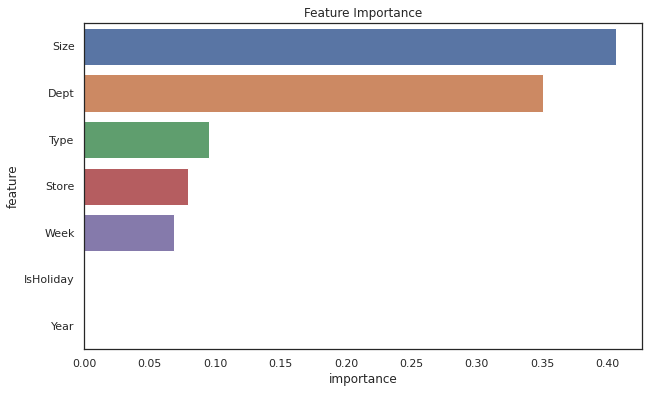

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [ ]:
# Make and evaluate predictions:
x_pred = model.predict(train_inputs)
x_pred

array([ 5759.526, 25476.402, 17486.178, ...,  9065.15 , 14393.386,
        9065.15 ], dtype=float32)

Evaluation

In [ ]:
# calculating mean_squared_error
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(x_pred,train_targets)

14521.463754491147

Making Prediction

In [ ]:
x_preds=model.predict(X_test)
x_preds

array([10074.297, 10074.297, 10074.297, ..., 10074.297, 10074.297,
       10074.297], dtype=float32)

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= x_preds

In [ ]:

sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission_XGB.csv',index=False)

In [ ]:
preds1=pd.read_csv('submission_XGB.csv')
preds1

,Id,Weekly_Sales
0,1_1_2012-11-02,10074.297
1,1_1_2012-11-09,10074.297
2,1_1_2012-11-16,10074.297
3,1_1_2012-11-23,10074.297
4,1_1_2012-11-30,10074.297
...,...,...
115059,45_98_2013-06-28,10074.297
115060,45_98_2013-07-05,10074.297
115061,45_98_2013-07-12,10074.297
115062,45_98_2013-07-19,10074.297


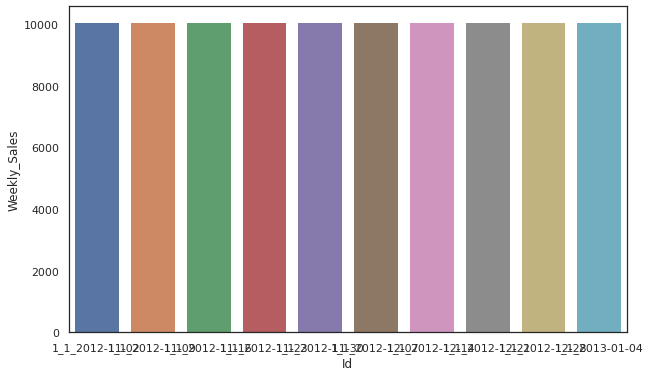

In [ ]:
#ploting prediction
plt.figure(figsize=(10,6))
sns.barplot(data=preds1.head(10), x='Id', y='Weekly_Sales');

Random Forest

In [ ]:
train_inputs, val_inputs, train_targets, val_targets=a,b,c,d

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [ ]:
test_params(n_estimators=20, max_depth=20)
test_params(n_estimators=50, max_depth=10,min_samples_split=3, min_samples_leaf=4, max_features=0.4)

(13979.727019777436, 14251.065303344923)

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

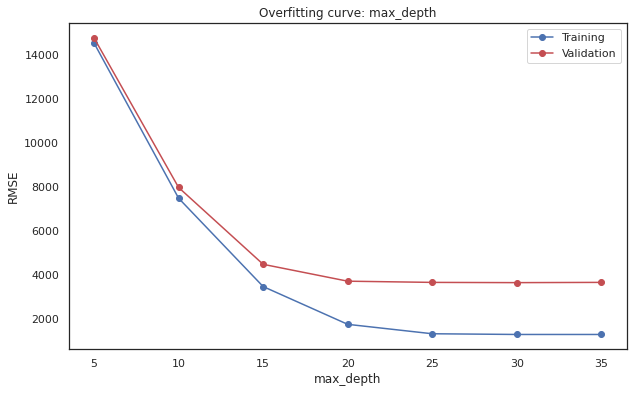

In [ ]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

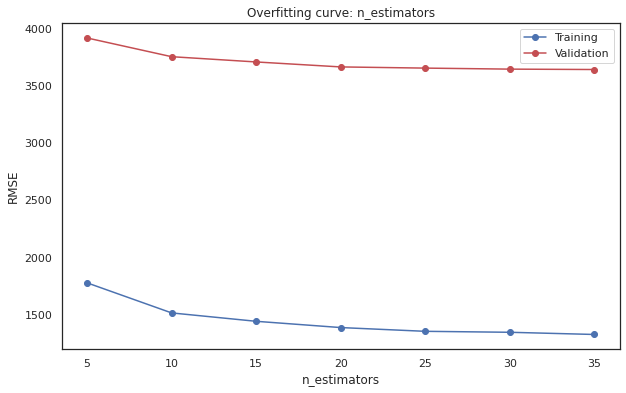

In [ ]:
test_param_and_plot('n_estimators', [5, 10, 15, 20, 25, 30, 35])

In [ ]:
# fitting the model with Hyperparameter Overfitting 
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

In [ ]:
RF.score(train_inputs, train_targets)

0.995212743610468

In [ ]:
#RF.score(val_inputs, val_targets)

In [ ]:
# Make and evaluate predictions:
train_preds = RF.predict(train_inputs)
train_preds

array([ 1678.69286351, 47652.80067529,  2133.41414943, ...,
       10629.62975715,  4968.18068391,  8248.49670194])

Evaluation

In [ ]:
rmse(train_targets,train_preds)

1567.7902656809622

Feature importance

In [ ]:
# Let's turn this into a dataframe and visualize the most important features.
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': RF.feature_importances_
}).sort_values('importance', ascending=False)

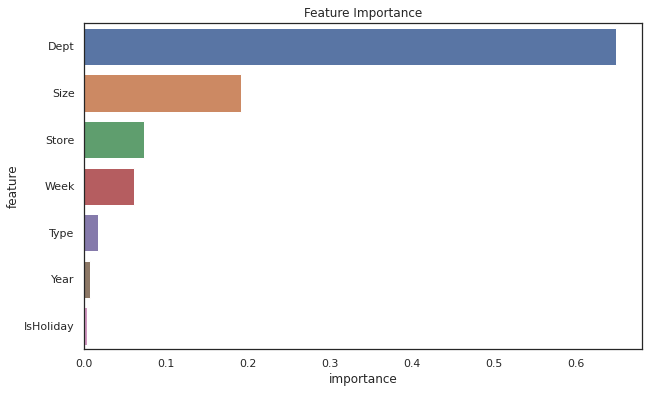

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Making Prediction

In [ ]:
predict = RF.predict(X_test)
predict

array([1233.27905172, 1233.27905172, 1233.27905172, ..., 1233.27905172,
       1233.27905172, 1233.27905172])

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= predict

In [ ]:
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission_RF.csv',index=False)
predicts=pd.read_csv('submission_RF.csv')
predicts

,Id,Weekly_Sales
0,1_1_2012-11-02,1233.279052
1,1_1_2012-11-09,1233.279052
2,1_1_2012-11-16,1233.279052
3,1_1_2012-11-23,1150.642931
4,1_1_2012-11-30,1233.279052
...,...,...
115059,45_98_2013-06-28,1233.279052
115060,45_98_2013-07-05,1233.279052
115061,45_98_2013-07-12,1233.279052
115062,45_98_2013-07-19,1233.279052


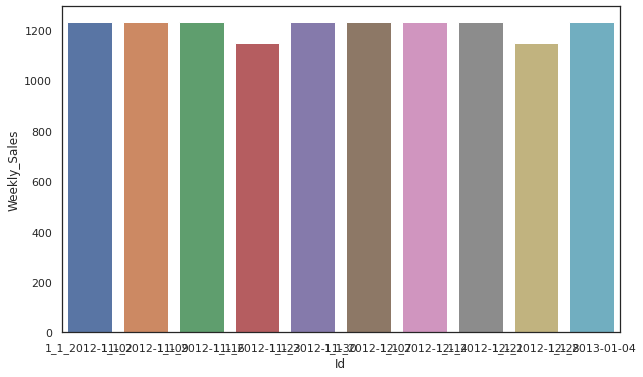

In [ ]:
#ploting prediction
plt.figure(figsize=(10,6))
sns.barplot(data=predicts.head(10), x='Id', y='Weekly_Sales');

Linear Regression

In [ ]:
train_inputs, val_inputs, train_targets, val_targets=e,f,g,h

In [ ]:
# importing the LinearRegression algorithm
from sklearn.linear_model import LinearRegression

In [ ]:
# fitting the model
lr=LinearRegression()
lr.fit(train_inputs,train_targets)

LinearRegression()

In [ ]:
Y_pred=lr.predict(train_inputs)
Y_pred

array([ 7224.95844055, 20107.16849899, 17198.15037196, ...,
       20193.3477649 , 21104.18986621, 23496.682457  ])

Evaluation

In [ ]:
rmse(train_targets,Y_pred)

21671.061045940456

Making Prediction

In [ ]:
y_pred=lr.predict(X_test)
y_pred

array([2.91161876e+09, 2.91162094e+09, 2.91162312e+09, ...,
       2.27562059e+09, 2.27562277e+09, 2.27562495e+09])

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= y_pred

In [ ]:
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission_LR.csv',index=False)

In [ ]:
preds=pd.read_csv('submission_LR.csv')
preds

,Id,Weekly_Sales
0,1_1_2012-11-02,2.911619e+09
1,1_1_2012-11-09,2.911621e+09
2,1_1_2012-11-16,2.911623e+09
3,1_1_2012-11-23,2.911626e+09
4,1_1_2012-11-30,2.911627e+09
...,...,...
115059,45_98_2013-06-28,2.275616e+09
115060,45_98_2013-07-05,2.275618e+09
115061,45_98_2013-07-12,2.275621e+09
115062,45_98_2013-07-19,2.275623e+09


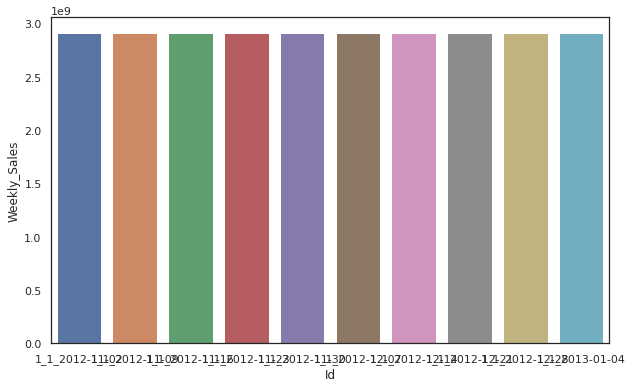

In [ ]:
#ploting prediction
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=preds.head(10),x='Id', y='Weekly_Sales');

In [ ]:
print(c)

150504     1782.11
216043    47855.02
295382     1973.49
279744     4110.46
377848      163.63
            ...   
259178    20775.91
365838     5350.00
131932    10939.87
146867     5013.89
121958     8103.12
Name: Weekly_Sales, Length: 316177, dtype: float64
